<a href="https://colab.research.google.com/github/PietroDF/Recommendation_system/blob/master/Recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Engine

Theory pills @ https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada

## Some theory 

The purpose of a recommender system is to suggest relevant items to users.
Interactions are stored in the “*user-item interactions matrix*”

There are two major paradigms of recommender systems: 
> **Collaborative filtering**

> The main idea that rules collaborative methods is that past user-item interactions are sufficient to detect similar users or similar items. 

> For this reason this method is affected by the *cold start problem*.

> The class of collaborative filtering algorithms is divided into two sub-categories:
  
>> **Memory based approach**
  
>> Memory based approaches directly works with values of recorded interactions, assuming no model, and are essentially based on nearest neighbours search

>> - **User-user**

>>> [*You may also like -> suggestion*]

>>> Two users are similar if they have interacted with a lot of common items in the same way

>>> *In general, every user have only interacted with a few items, it makes the method pretty sensitive to any recorded interactions (high variance, low bias)*

>> - **Item-item**

>>> [*People who watched this, also watched -> suggestion*]

>>> Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way

>>> *As lot of users have interacted with an item, the neighbourhood search is far less sensitive to single interactions (lower variance). As a counterpart, interactions coming from every kind of users (even users very different from our reference user) are then considered in the recommendation, making the method less personalised (low variance, high bias), so this approach is less personalized than the user-user approach but more robust*.

>> **Model based approach**

>> Model based approaches assume an underlying “generative” model that explains the user-item interactions

>> - **Matrix-factorization**

>>> There exists a pretty low dimensional latent space of features in which we can represent both users and items; extracted features taken individually have a mathematical meaning but no intuitive interpretation

> **Content based methods**

> Content based approaches use *additional information* about users and/or items (ie. age,sex, job for users; category, price for item). 

> The main idea is to try to build a model, based on the available “features”, that explain the observed user-item interactions, and for this reason they suffer less from cold start problem.

> The problem can be expressed in two ways:
> 1. Classification -> like/dislike
> 2. Regression -> user rating

> *Either of these cases can be modelled following the two possibile approaches*:

>> **Item centered approach**

>> [*what is the probability for each user to like this item?*]

>> For each item, build a classifier/regressor. Given user's features predict whether she likes or not the item

>> Users Feature -> Item specific Model -> Prediction

>> **User centered approach**

>> [*what is the probability for this user to like each item?*]

>> For each user, build a classifier/regressor. Given items's features predict whether the users likes or not that item

>> Items Feature -> Users specific Model -> Prediction

**Summary**

- **Memory based collaborative methods**

> do not assume any latent model and have then:

> - low bias
> - high variance

-  **Model based collaborative methods**

> assume a latent interactions model that needs to learn both users and items representations from scratch and have

> - higher bias
> - lower variance

- **Content based methods**

> assume a latent model build around users and/or items features explicitly given and have

> - highest bias
> - lowest variance


**Note on Evaluation**

Recommender systems are difficult to evaluate: if some classical metrics such that MSE, accuracy, recall or precision can be used, one should keep in mind that some desired properties such as diversity (serendipity) and explainability can’t be assessed this way ; real conditions evaluation (like A/B testing or sample testing) is finally the only real way to evaluate a new recommender system but requires a certain confidence in the model














# Import

Movie Dataset @ http://files.grouplens.org/datasets/movielens/ml-25m.zip

Inspiring tutorial @ https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d

## Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [0]:
# Create destination directory
!mkdir '/content/dataset_directory'

In [0]:
# Download dataset
!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-25m.zip \
    -O /content/dataset_directory/recommender_dataset.zip

--2020-04-26 13:04:26--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘/content/dataset_directory/recommender_dataset.zip’

/content/dataset_di 100%[===================>] 249.84M  17.0MB/s    in 16s     

2020-04-26 13:04:42 (15.6 MB/s) - ‘/content/dataset_directory/recommender_dataset.zip’ saved [261978986/261978986]



In [0]:
# Unzip the dataset into the destination directory
!unzip /content/dataset_directory/recommender_dataset.zip -d /content/dataset_directory

Archive:  /content/dataset_directory/recommender_dataset.zip
   creating: /content/dataset_directory/ml-25m/
  inflating: /content/dataset_directory/ml-25m/tags.csv  
  inflating: /content/dataset_directory/ml-25m/links.csv  
  inflating: /content/dataset_directory/ml-25m/README.txt  
  inflating: /content/dataset_directory/ml-25m/ratings.csv  
  inflating: /content/dataset_directory/ml-25m/genome-tags.csv  
  inflating: /content/dataset_directory/ml-25m/genome-scores.csv  
  inflating: /content/dataset_directory/ml-25m/movies.csv  


In [0]:
# Remove the zipped dataset
!rm /content/dataset_directory/recommender_dataset.zip

# Data exploration

In [0]:
movies = pd.read_csv('/content/dataset_directory/ml-25m/movies.csv')

In [0]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# In case one would read the file in pieces
# chunked_ratings = pd.read_csv('/content/dataset_directory/ml-25m/ratings.csv', sep=',', chunksize=1000)
# Then apply a for cycle

In [0]:
ratings = pd.read_csv('/content/dataset_directory/ml-25m/ratings.csv')

In [0]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [0]:
# Take a subset to easily handle pivot operation
subset_list_of_movies_by_id = np.arange(20)
ratings = ratings[ratings['movieId'].isin(subset_list_of_movies_by_id)]

In [0]:
pv_table = ratings.pivot_table(values='rating',index='userId',columns='movieId', fill_value=0)

In [0]:
pv_table.tail(10)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
userId,,,,,,,,,,,,,,,,,,,
162520,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162521,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162524,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.5
162527,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162529,2.0,4.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0
162530,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162533,4.5,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.0
162534,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Collaborative filtering

## Item based collaborative model

In [0]:
import random

In [0]:
# Choose a movie to fine the most similar items
rnd_movie = int(random.choice(pv_table.columns))
rnd_movie

7

In [0]:
item_ratings = pv_table[rnd_movie]

In [0]:
# find correlation between movie_watched and other movies
similarity_with_other_movies = pv_table.corrwith(item_ratings)

In [0]:
# Sort to fine the most similar
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)

In [0]:
# Show the most similar, but remember to exclude the first (the most similar to herself!)
similarity_with_other_movies.head()

movieId
7     1.000000
5     0.318883
3     0.301246
17    0.256258
11    0.245223
dtype: float64

## User based collaborative model

### Perform clustering
To improve system performances, I will look for similar users only inside her cluster

In [0]:
from sklearn.cluster import KMeans as kms

In [0]:
filling_value = np.mean(np.mean(pv_table))

In [0]:
# Identify the k parameter for kMeans
cluster_to_try = [5,10,25,60,120,300,600]
model_cost = []

for num_clust in cluster_to_try:
  print('num clust:'+str(num_clust))
  kmeans_model = kms(n_clusters=num_clust, random_state=0).fit(pv_table.fillna(0))
  model_cost.append(kmeans_model.inertia_)

num clust:5
num clust:10
num clust:25
num clust:60
num clust:120
num clust:300
num clust:600


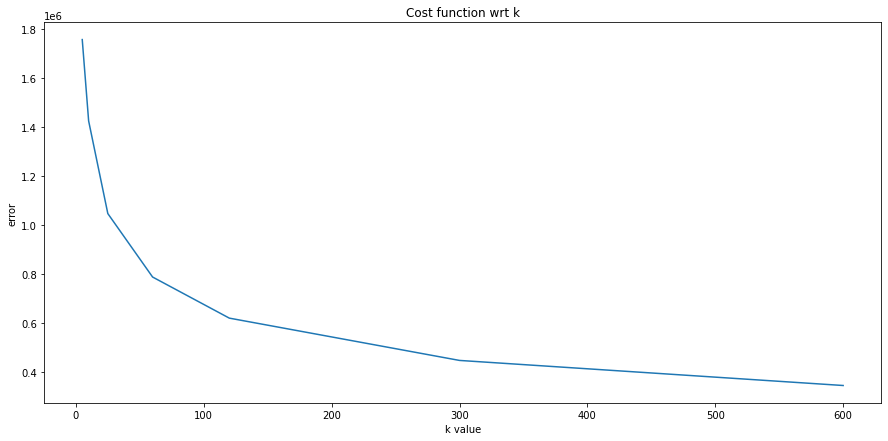

In [0]:
# Plot the cost function
fig = plt.figure(figsize = (15,7))
plt.plot(cluster_to_try,model_cost)
plt.title('Cost function wrt k')
plt.xlabel('k value')
plt.ylabel('error')
plt.show()

In [0]:
# Elbow method - scelgo miglior cluster
best_k = 120

In [0]:
# Calcolo il modello sul k scelto
kmeans_model = kms(n_clusters=best_k, random_state=0).fit(pv_table.fillna(filling_value))

In [0]:
# Seleziono un intero a caso da 0 a num_users
rnd_user = np.random.randint(pv_table.shape[0])

In [0]:
# Estraggo la riga realtiva all'utente
rnd_user_row = pv_table.iloc[rnd_user,:].fillna(filling_value)

In [0]:
# Calcolo il cluster di appartenenza
user_cluster_label = kmeans_model.predict(np.array(rnd_user_row).reshape(1, -1))[0]

In [0]:
# L'utente appartiene al cluster numero:
user_cluster_label

1

In [0]:
# Prendo una msk di tutti gli utenti che appartengono allo stesso cluster
idx_user_cluster = kmeans_model.labels_ == user_cluster_label

### Calculate correlation
Performa this calculation among people in the same cluster



In [0]:
# Quanti utenti contiene quel cluster?
np.sum(idx_user_cluster)

12043

In [0]:
# Use mask to filter out people not in the same cluster as our user
users_in_cluster = pv_table[idx_user_cluster]

In [0]:
# Check the dimension of the table
users_in_cluster.shape

(12043, 19)

In [0]:
# Inspect the values in the table
users_in_cluster.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
userId,,,,,,,,,,,,,,,,,,,
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Calcola le correlazioni con gli altri utenti del dataframe
user_corr = users_in_cluster.corrwith(rnd_user_row, axis = 1)

In [0]:
# Check the dimension of the correlation
user_corr.shape

(12043,)

In [0]:
# Inspect the dataset
user_corr.head()

userId
3     1.0
50    1.0
51    1.0
64    1.0
82    1.0
dtype: float64

In [0]:
# Sort the values to see the correlation associated with the most similar users 
user_corr_sorted = user_corr.sort_values(ascending=False)

In [0]:
# Inspect the dataset
user_corr_sorted.tail()

userId
46652     0.736559
122681    0.730794
61484     0.726483
105830    0.726483
11394     0.708197
dtype: float64

In [0]:
user_corr_sorted.shape

(12013,)

In [0]:
# Filter only the best positively correlated users
user_corr_sorted = user_corr_sorted[user_corr_sorted>0.5]

In [0]:
user_corr_sorted.index

Int64Index([162534,  66849,  66955,  66918,  66915,  66898,  66856,  66850,
             66847,  66982,
            ...
            129904,  80592,  84058,  95042, 157642,  46652, 122681,  61484,
            105830,  11394],
           dtype='int64', name='userId', length=12013)

In [0]:
# make a full copy of the table
recommender_table = users_in_cluster[:]

In [0]:
# Filter only the correlated users
recommender_table = recommender_table.loc[user_corr_sorted.index]

In [0]:
# Add the correlation column
recommender_table['correlation'] = user_corr_sorted

In [0]:
# Inspect the table
recommender_table.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,correlation
userId,,,,,,,,,,,,,,,,,,,,
162534,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66849,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66955,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66918,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66915,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Calculate recommendations

In [0]:
calculated_user = rnd_user_row[:].rename("predicted")
recommender_table_prova = recommender_table[:]

for i in recommender_table.columns[:-1]:
  recommender_table_prova[i] = recommender_table[i]*recommender_table['correlation']

  temp_df = recommender_table_prova[recommender_table[i]>0]

  if np.sum(temp_df['correlation']) > 0:
    calculated_user[i] = np.round(np.sum(temp_df[i])/np.sum(temp_df['correlation']),3)

In [0]:
calculated_user = pd.concat([calculated_user, rnd_user_row.rename('actual'), (calculated_user-rnd_user_row).rename('difference')], axis=1)

In [0]:
calculated_user.T

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predicted,4.447,1.028,1.525,2.425,0.97,1.342,0.703,2.853,2.923,0.862,1.387,2.324,2.013,2.909,2.332,1.587,1.583,1.572,0.95
actual,4.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00
difference,0.447,1.028,1.525,2.425,0.97,1.342,0.703,2.853,2.923,0.862,1.387,2.324,2.013,2.909,2.332,1.587,1.583,1.572,0.95


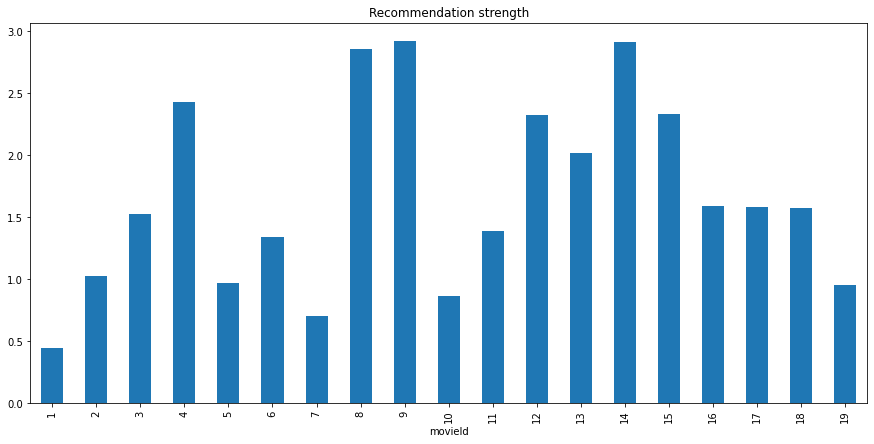

In [0]:
fig = calculated_user['difference'].plot.bar(figsize = (15,7), title='Recommendation strength')